In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datacompy
import os
import numpy as np
from joblib import dump, load
import pickle
from scipy.io import arff

# narzedzia
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_val_predict,
    learning_curve,
    RepeatedStratifiedKFold,
    GridSearchCV
)
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.preprocessing import LabelEncoder

# modele + Smote
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.under_sampling import NearMiss, RandomUnderSampler, EditedNearestNeighbours, TomekLinks, NeighbourhoodCleaningRule, InstanceHardnessThreshold, OneSidedSelection, CondensedNearestNeighbour
from ctgan import CTGAN

### Data Preprocessing

Focuse on service == http, drop columns which have the same values in all rows ('protocol_type', 'land', 'wrong_fragment', 'urgent', 'num_failed_logins', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_outbound_cmds', 'is_host_login', 'is_guest_login'). drop columns "index" and "flag" after dummies this column. Swap class from values "normaly" & "anomaly" to 1 & 0. 

In [10]:
#read data & use only http services
df = pd.read_csv("..\\data\\IPS\\Train_data.csv")
df = df[df['service'].str.contains('http')]
df = df[df['service'] != 'http_8001']
df = df.drop(columns=["service"])
df = df.reset_index()
df = df.drop(columns=["protocol_type"])
df = df.drop(columns=["index"])

(8116,)


<Axes: xlabel='class'>

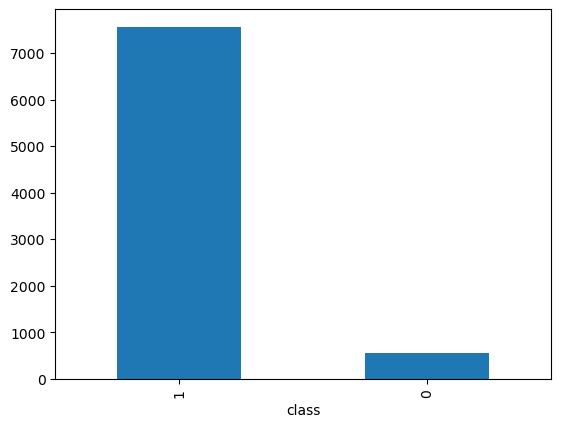

In [11]:
#split column flag
df_dumm = pd.get_dummies(df["flag"], prefix="flag", dtype=int)
col = df.columns.get_loc('flag')+1
for col_name in reversed(df_dumm.columns):  
    df.insert(col, col_name, df_dumm[col_name])
df = df.drop(columns=["flag"])

#drop columns with one value f.g. 1 in all rows
df['class'] = df['class'].replace({'normal': 1, 'anomaly': 0})
df = df.drop(columns=['land', 'wrong_fragment', 'urgent', 'num_failed_logins', 'su_attempted',
       'num_root', 'num_file_creations', 'num_shells', 'num_outbound_cmds',
       'is_host_login', 'is_guest_login'])
df.to_excel("D:\\ml\\xgboost-main\\data\\IPS\\http_data.xlsx")

#print column class distribution
colum = df['class']
print(colum.shape)
pd.Series(colum).value_counts().plot.bar()

### Training & Test Data

In [17]:
#X and y 
X = df.drop(columns=['class'])
y = df['class']

#split data on test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#concat X_train & y_train -> used to save files
df_train = pd.concat([X_train, y_train], axis=1)          
df_train['source'] = 'original'  
df_train.to_csv("D:\\ml\\xgboost-main\\data\\IPS\\original_data.csv")

#save test samples
y_test.to_csv("D:\\ml\\xgboost-main\\data\\IPS\\test_data\\y_test.csv")
X_test.to_csv("D:\\ml\\xgboost-main\\data\\IPS\\test_data\\X_test.csv")

## OVERSAMPLING

### SMOTE

Przed Counter({1: 6045, 0: 447})
Po Counter({1: 6045, 0: 6045})
(12090, 37) (12090,)


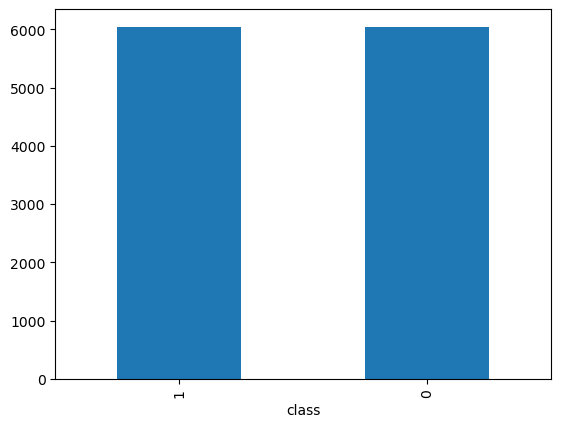

In [18]:
file_path1 = "D:\\ml\\xgboost-main\\data\\IPS\\smote_data.csv"
#generate new data by SMOTE
con = Counter(y_train)
print("Przed", con)
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
con1 = Counter(y_train_sm)
print("Po", con1)

#concat smote train X & y && save data
train_data_smote = pd.concat([X_train_sm, y_train_sm], axis=1)          #polaczenie danych wygenerowanych X_train oraz y_train
train_data_smote['generated_by_smote'] = ['original' if i < len(df_train) else 'smote' for i in range(len(train_data_smote))]
smote_data = train_data_smote[train_data_smote['generated_by_smote'] == 'smote'].drop('generated_by_smote', axis=1)
smote_data["source"]="smote"

if not os.path.exists(file_path1):
    smote_data.to_csv(file_path1, index=False)
else:
    print(f'Plik istnieje pod ścieżką: {file_path1}')

pd.Series(y_train_sm).value_counts().plot.bar()

### BorderLine SMOTE

Przed Counter({1: 6045, 0: 447})
Po Counter({1: 6045, 0: 6045})


<Axes: xlabel='class'>

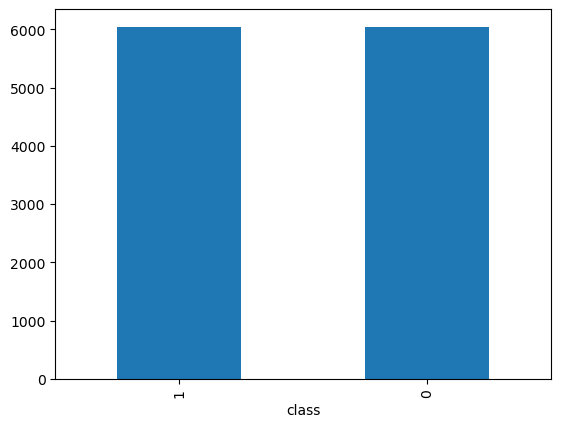

In [19]:
file_path2 = "D:\\ml\\xgboost-main\\data\\IPS\\borderlinesmote_data.csv"
#generate new data by borderLineSMOTE
con3 = Counter(y_train)
print("Przed", con3)
brdsmote = BorderlineSMOTE(random_state=42)
X_train_bsm, y_train_bsm = brdsmote.fit_resample(X_train, y_train)
con4 = Counter(y_train_bsm)
print("Po", con4)

train_data_borderline_smote = pd.concat([X_train_bsm, y_train_bsm], axis=1)          #polaczenie danych wygenerowanych X_train oraz y_train
train_data_borderline_smote['generated_by_borderline_smote'] = ['original' if i < len(df_train) else 'brd smote' for i in range(len(train_data_borderline_smote))]
borderline_smote_data = train_data_borderline_smote[train_data_borderline_smote['generated_by_borderline_smote'] == 'brd smote'].drop('generated_by_borderline_smote', axis=1)
borderline_smote_data["source"]="borderline smote"
if not os.path.exists(file_path2):
    borderline_smote_data.to_csv(file_path2, index=False)
else:
    print(f'Plik istnieje pod ścieżką: {file_path2}')

pd.Series(y_train_bsm).value_counts().plot.bar()

### GAN

Dane wygenerowane:  class
0    5598
Name: count, dtype: int64
Before Counter({1: 6045, 0: 447})
After Counter({1: 6045, 0: 6045})


<Axes: xlabel='class'>

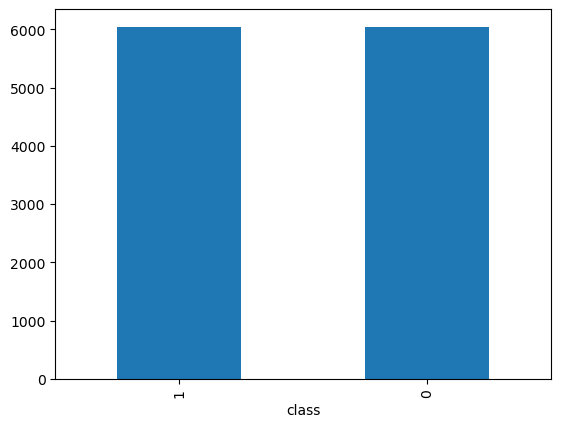

In [20]:
file_path3 = "D:\\ml\\xgboost-main\\data\\IPS\\GAN_data.csv"        #sciezka wraz z nazwa pod jaka wygenerowac plik
#generate new data by GAN
columns_list = df_train.columns
target_num = df_train['class'].value_counts()
ctgan = CTGAN(epochs=10)        #model

if target_num[0] > target_num[1]:
    data_y1 = df_train[df_train['']==1]
    ctgan.fit(data_y1, columns_list)
    sample = abs(target_num[0]-target_num[1])
    df_GAN = ctgan.sample(sample)
    print('Dane wygenerowane: ', df_GAN['class'].value_counts())
    balanced_data = pd.concat([df_train, df_GAN], ignore_index=False)
else:
    data_y0 = df_train[df_train['class']==0]
    ctgan.fit(data_y0, columns_list)
    sample = abs(target_num[0]-target_num[1])
    df_GAN = ctgan.sample(sample)
    print('Dane wygenerowane: ', df_GAN['class'].value_counts())
    balanced_data = pd.concat([df_train, df_GAN], ignore_index=False)

balanced_data = balanced_data.drop(columns=["source"])  
y_train_gan = balanced_data["class"]
X_train_gan = balanced_data.drop(columns=["class"])
con5 = Counter(y_train)
print("Before", con5)
con6 = Counter(y_train_gan)
print("After", con6)
df_GAN["source"]="gan"
gan_data = df_GAN
if not os.path.exists(file_path3):
    gan_data.to_csv(file_path3, index=False)
else:
    print(f'Plik istnieje pod ścieżką: {file_path3}')

pd.Series(y_train_gan).value_counts().plot.bar()

### Models & fit_data

In [ ]:
models = {
    "LR": LogisticRegression(),
    "LR_SMOTE": LogisticRegression(),
    "LR_BrdSMOTE": LogisticRegression(),
    "LR_GAN": LogisticRegression(),
    
    "DT": DecisionTreeClassifier(),
    "DT_SMOTE": DecisionTreeClassifier(),
    "DT_BrdSMOTE": DecisionTreeClassifier(),
    "DT_GAN": DecisionTreeClassifier(),
    
    "RF": RandomForestClassifier(),
    "RF_SMOTE": RandomForestClassifier(),
    "RF_BrdSMOTE": RandomForestClassifier(),
    "RF_GAN": RandomForestClassifier(),
    
    "XGB": XGBClassifier(),
    "XGB_SMOTE": XGBClassifier(),
    "XGB_BrdSMOTE": XGBClassifier(),
    "XGB_GAN": XGBClassifier(),
    
    "XGB_RF": XGBRFClassifier(),
    "XGB_RF_SMOTE": XGBRFClassifier(),
    "XGB_RF_BrdSMOTE": XGBRFClassifier(),
    "XGB_RF_GAN": XGBRFClassifier()
}


fit_data = {
    
    "LR": (X_train, y_train),
    "LR_SMOTE": (X_train_sm, y_train_sm),
    "LR_BrdSMOTE": (X_train_bsm, y_train_bsm),
    "LR_GAN": (X_train_gan, y_train_gan),
    
    "DT": (X_train, y_train),
    "DT_SMOTE": (X_train_sm, y_train_sm),
    "DT_BrdSMOTE": (X_train_bsm, y_train_bsm),
    "DT_GAN": (X_train_gan, y_train_gan),
    
    "RF": (X_train, y_train),
    "RF_SMOTE": (X_train_sm, y_train_sm),
    "RF_BrdSMOTE": (X_train_bsm, y_train_bsm),
    "RF_GAN": (X_train_gan, y_train_gan),
    
    "XGB": (X_train, y_train),
    "XGB_SMOTE": (X_train_sm, y_train_sm),
    "XGB_BrdSMOTE": (X_train_bsm, y_train_bsm),
    "XGB_GAN": (X_train_gan, y_train_gan),

    "XGB_RF": (X_train, y_train),
    "XGB_RF_SMOTE": (X_train_sm, y_train_sm),
    "XGB_RF_BrdSMOTE": (X_train_bsm, y_train_bsm),
    "XGB_RF_GAN": (X_train_gan, y_train_gan)
}

### GridSearch

In [ ]:
#time +- 140min
params = {
    #LR
    "LR": {
        'max_iter': [100, 500, 1000],       # Liczba iteracji
        'random_state': [0, 10, 20, 30, 40]}, # Losowość dla powtarzalności
    
    "LR_SMOTE": {
        'max_iter': [100, 500, 1000],
        'random_state': [0, 10, 20, 30, 40]},
    
    "LR_BrdSMOTE": {
        'max_iter': [100, 500, 1000],
        'random_state': [0, 10, 20, 30, 40]},
    
    "LR_GAN": {
        'max_iter': [100, 500, 1000],
        'random_state': [0, 10, 20, 30, 40]},
    
    #DT
    "DT": {
        'max_depth':[4,8,12,16],                # maksymalna głębokość drzewa
        'random_state':[0,10,20,30,40],         # ustalona losowość dla powtarzalności
        'min_samples_leaf':[1,2]},              # minimalna ilosc probek lisci
    
    "DT_SMOTE": {
        'max_depth':[4,8,12,16],                
        'random_state':[0,10,20,30,40],         
        'min_samples_leaf':[1,2]},
    
    "DT_BrdSMOTE": {
        'max_depth':[4,8,12,16],                
        'random_state':[0,10,20,30,40],         
        'min_samples_leaf':[1,2]},
    
    "DT_GAN": {
        'max_depth':[4,8,12,16],                
        'random_state':[0,10,20,30,40],         
        'min_samples_leaf':[1,2]},
    
    #RF
    "RF": {
        'n_estimators':[20,40,60,80,100],       # rozmiar lasu
        'max_depth':[4,8,12,16],                # maksymalna głębokość drzewa
        'min_samples_leaf':[1,2],               # minimalna ilosc probek lisci
        'random_state':[0,10,20,30,40]},         # ustalona losowość dla powtarzalności
    
    "RF_SMOTE": {
        'n_estimators':[20,40,60,80,100],      
        'max_depth':[4,8,12,16],              
        'min_samples_leaf':[1,2],               
        'random_state':[0,10,20,30,40]},        

    "RF_BrdSMOTE": {
        'n_estimators':[20,40,60,80,100],      
        'max_depth':[4,8,12,16],              
        'min_samples_leaf':[1,2],               
        'random_state':[0,10,20,30,40]},    
    
    "RF_GAN": {
        'n_estimators':[20,40,60,80,100],      
        'max_depth':[4,8,12,16],              
        'min_samples_leaf':[1,2],               
        'random_state':[0,10,20,30,40]},    
    
    #XGB
    "XGB": {
        'max_depth':[4,8,12,16],                # maksymalna głębokość drzewa
        'subsample':[0.5,0.6,0.7,0.8,0.9,1]},
    
    "XGB_SMOTE": {
        'max_depth':[4,8,12,16],                
        'subsample':[0.5,0.6,0.7,0.8,0.9,1]},
    
    "XGB_BrdSMOTE": {
        'max_depth':[4,8,12,16],                
        'subsample':[0.5,0.6,0.7,0.8,0.9,1]},
    
    "XGB_GAN": {
        'max_depth':[4,8,12,16],                
        'subsample':[0.5,0.6,0.7,0.8,0.9,1]},
    
    #XGB_RF
    "XGB_RF": {
        'max_depth':[4,8,12,16],                # maksymalna głębokość drzewa
        'n_estimators':[20,40,60,80,100],       # rozmiar lasu
        'subsample':[0.5,0.6,0.7,0.8,0.9,1],
        'random_state':[0,10,20,30,40]},        # ustalona losowość dla powtarzalności
    
    "XGB_RF_SMOTE": {
        'max_depth':[4,8,12,16],                
        'n_estimators':[20,40,60,80,100],       
        'subsample':[0.5,0.6,0.7,0.8,0.9,1],
        'random_state':[0,10,20,30,40]},    
    
    "XGB_RF_BrdSMOTE": {
        'max_depth':[4,8,12,16],                
        'n_estimators':[20,40,60,80,100],       
        'subsample':[0.5,0.6,0.7,0.8,0.9,1],
        'random_state':[0,10,20,30,40]},  
    
    "XGB_RF_GAN": {
        'max_depth':[4,8,12,16],                
        'n_estimators':[20,40,60,80,100],       
        'subsample':[0.5,0.6,0.7,0.8,0.9,1],
        'random_state':[0,10,20,30,40]}     
}
path_files = ["D:\\ml\\xgboost-main\\reports\\gridsearch_IPS\\precision_metrics.txt", 
              "D:\\ml\\xgboost-main\\reports\\gridsearch_IPS\\f1_metrics.txt", 
              "D:\\ml\\xgboost-main\\reports\\gridsearch_IPS\\recall_metrics.txt", 
              "D:\\ml\\xgboost-main\\reports\\gridsearch_IPS\\accuracy_metrics.txt"]
excel_file = "D:\\ml\\xgboost-main\\reports\\gridsearch_IPS\\results.xlsx"
excel_file1 = "D:\\ml\\xgboost-main\\reports\\gridsearch_IPS\\std.xlsx"
excel_file2 = "D:\\ml\\xgboost-main\\reports\\gridsearch_IPS\\best.xlsx"
name_sheet1 = "Arkusz1"
name_sheet2 = "Arkusz2"
results1 = []
results2 = []
results3 = []
goal = ['precision', 'recall', 'f1', 'accuracy']

for metrix1 in goal:
    for model_name, model in models.items():
        
        X_train, y_train = fit_data[model_name]
        params_ = params[model_name]
        model_Grid = GridSearchCV(model,param_grid=params_,scoring=metrix1, n_jobs=-1).fit(X_train,y_train)
            
        #save to txt file
        results1.append({
        "Model": model_name,
        "Metric": metrix1,
        "Result": model_Grid.best_score_})
        results2.append({
        "Model": model_name,
        "Metric": metrix1,
        "Std":model_Grid.cv_results_['std_test_score'][model_Grid.best_index_]})
        results3.append({
        "Model": model_name,
        "Metric": metrix1,
        "Best":model_Grid.best_params_})
        df_results1 = pd.DataFrame(results1)
        df_results2 = pd.DataFrame(results2)
        df_results3 = pd.DataFrame(results3)
        df_save_mean = df_results1.pivot(index="Metric", columns="Model", values="Result")
        df_save_std = df_results2.pivot(index="Metric", columns="Model", values="Std")
        df_save_std2 = df_results3.pivot(index="Metric", columns="Model", values="Best")
        with pd.ExcelFile(excel_file) as w:
            df_save_mean.to_excel(w, sheet_name=name_sheet1)
        with pd.ExcelFile(excel_file1) as w1:
            df_save_std.to_excel(w1, sheet_name=name_sheet1)
        with pd.ExcelFile(excel_file2) as w2:
            df_save_std2.to_excel(w2, sheet_name=name_sheet1)
            
        